In [194]:
import gc
import numpy as np
import pandas as pd
import polars as pl
from tqdm.auto import tqdm
from matplotlib import pyplot as plt
import os

In [262]:
df_result = pd.read_csv(r"..\CMI\unet\1layer_cosine\df_sub_with_pp.csv")
df_true = pd.read_csv("train_events.csv")

In [263]:
df_true = df_true.dropna()
df_true['step'] = df_true['step'].astype(int)
df_true = df_true[['series_id',	'night', 'event', 'step']]
df_result = df_result[['series_id', 'event', 'step', 'score']]

In [264]:
df_result

,series_id,event,step,score
0,038441c925bb,onset,29,0.018879
1,038441c925bb,wakeup,77,0.006599
2,038441c925bb,onset,137,0.004672
3,038441c925bb,onset,257,0.007497
4,038441c925bb,onset,389,0.005363
...,...,...,...,...
199995,fe90110788d2,wakeup,581837,0.034846
199996,fe90110788d2,onset,591485,0.003828
199997,fe90110788d2,onset,591569,0.003971
199998,fe90110788d2,onset,591641,0.003771


In [265]:
df_true

,series_id,night,event,step
0,038441c925bb,1,onset,4992
1,038441c925bb,1,wakeup,10932
2,038441c925bb,2,onset,20244
3,038441c925bb,2,wakeup,27492
4,038441c925bb,3,onset,39996
...,...,...,...,...
14501,fe90110788d2,32,wakeup,547152
14502,fe90110788d2,33,onset,556560
14503,fe90110788d2,33,wakeup,560604
14504,fe90110788d2,34,onset,574620


In [266]:
# Assuming df_true and df_result are your two DataFrames and they're already sorted by 'step'
# Add a tolerance range to df_true
df_true_ = df_true
df_true_['step_min'] = df_true['step'] - 360
df_true_['step_max'] = df_true['step'] + 360

# Initialize a list to hold the results
matched_results = []

# Iterate through df_true DataFrame
for idx, row in df_true_.iterrows():
    series_id = row['series_id']
    event = row['event']
    step_min = row['step_min']
    step_max = row['step_max']
    night = row['night']

    # Find matching rows in df_result within the step range for the same series_id and event
    matches = df_result[
        (df_result['series_id'] == series_id) &
        (df_result['event'] == event) &
        (df_result['step'] >= step_min) &
        (df_result['step'] <= step_max)
    ]

    # If matches are found, append them to the results list
    for match_idx, match_row in matches.iterrows():
        matched_results.append({
            'series_id': series_id,
            'event': event,
            'step_true': row['step'],
            'step_pred': match_row['step'],
            'score': match_row['score'],  # Assuming df_result has a 'score' column
            'night': row['night']
        })

# Convert the matched results to a DataFrame
df_matched_results = pd.DataFrame(matched_results)

# Now df_matched_results contains all the matching rows within the specified step range

In [267]:
df_matched_results['error'] = (df_matched_results['step_pred'] - df_matched_results['step_true']).abs()

tolerances = [0, 12, 36, 60, 90, 120, 150, 180, 240, 300]
correctness = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

def categorize_error(error, tolerances):
    for idx, tolerance in enumerate(reversed(tolerances)):
        if error > tolerance:
            return (f'>{tolerance} steps', correctness[idx])

df_matched_results['error_category'] = df_matched_results['error'].apply(lambda x: categorize_error(x, tolerances)[0])
df_matched_results['correctness'] = df_matched_results['error'].apply(lambda x: categorize_error(x, tolerances)[1])

In [268]:
def get_grouped_dfs(df):
    grouped_dfs = []

    for series_id, group in df.groupby('series_id'):
        # Sort by night, event (onset before wakeup), and score
        sorted_group = group.sort_values(['night', 'event', 'score'], ascending=[True, True, False])
        grouped_dfs.append(sorted_group)

    return grouped_dfs

# Get the list of DataFrames grouped by series_id
grouped_dfs = get_grouped_dfs(df_matched_results)

In [269]:
def calculate_top_6_score_and_target(df):
    # Sort the DataFrame by night, event, and score in descending order
    df_sorted = df.sort_values(by=['night', 'event', 'score'], ascending=[True, True, False])

    # Group by series_id, night, and event
    grouped = df_sorted.groupby(['night', 'event'])

    # Get top 6 rows for each group
    top_6_df = grouped.head(6)

    # Calculate the cumulative max of the correctness to find the highest correctness so far
    top_6_df['top_6_score'] = grouped['correctness'].cummax()
    top_6_df['target'] = (top_6_df['top_6_score'] > 0.5).astype(int)

    return top_6_df

final_dfs = []
for df in grouped_dfs:
  df_new = calculate_top_6_score_and_target(df)
  df_new['daily_step'] = df_new['step_pred'] % (12*60*24) / (12*60*24)
  df_new['top_6_score_diff'] = df_new.groupby('step_true')['top_6_score'].diff()
  df_new['top_6_score_diff'] = df_new['top_6_score_diff'].fillna(df_new['top_6_score'])
  final_dfs.append(df_new.reset_index(drop=True))

C:\Users\user\AppData\Local\Temp\ipykernel_27472\2916592683.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_6_df['top_6_score'] = grouped['correctness'].cummax()
C:\Users\user\AppData\Local\Temp\ipykernel_27472\2916592683.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_6_df['target'] = (top_6_df['top_6_score'] > 0.5).astype(int)
C:\Users\user\AppData\Local\Temp\ipykernel_27472\2916592683.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

In [270]:
final_dfs[207]

,series_id,event,step_true,step_pred,score,night,error,error_category,correctness,top_6_score,target,daily_step,top_6_score_diff
0,cf13ed7e457a,onset,8748,8813,0.149458,1,65,>60 steps,0.7,0.7,1,0.510012,0.7
1,cf13ed7e457a,onset,8748,8741,0.034663,1,7,>0 steps,1.0,1.0,1,0.505845,0.3
2,cf13ed7e457a,onset,8748,8933,0.009928,1,185,>180 steps,0.3,1.0,1,0.516956,0.0
3,cf13ed7e457a,onset,8748,9077,0.008486,1,329,>300 steps,0.1,1.0,1,0.525289,0.0
4,cf13ed7e457a,wakeup,13440,13445,0.653528,1,5,>0 steps,1.0,1.0,1,0.778067,1.0
5,cf13ed7e457a,wakeup,13440,13577,0.015487,1,137,>120 steps,0.5,1.0,1,0.785706,0.0


In [271]:
df_pred = pd.read_csv('unet/df_pred.csv')

In [272]:
lengthlist = [12, 24, 60, 120, 240, 360, 720]
score_keys = ['score']

def calculate_window_features(group, df_pred):
    # scores = group['score'].values
    steps = group['step_pred'].values

    for length in lengthlist:

        before_means = []
        after_means = []
    
        for step in steps:
            # Indices for window before and after
            before_indices = (df_pred['step'] < step) & (df_pred['step'] >= step - length)
            after_indices = (df_pred['step'] > step) & (df_pred['step'] <= step + length)
            
            # Calculate mean scores
            before_mean = df_pred.loc[before_indices, 'score'].mean()
            after_mean = df_pred.loc[after_indices, 'score'].mean()
            
            before_means.append(before_mean)
            after_means.append(after_mean)
        
        group[f'before_states_feat_{length}'] = before_means
        group[f'after_states_feat_{length}'] = after_means
    
    return group

result_df = pd.DataFrame()
# for (series_id, event), group in df.groupby(['series_id', 'event']):
#     matched_df_pred = df_pred[df_pred['series_id'] == series_id]
#     print(matched_df_pred)
#     result_df = pd.concat([result_df, calculate_window_features(group, matched_df_pred)])

for group in final_dfs:
    matched_df_pred = df_pred[df_pred['series_id'] == group['series_id'][0]]
    # print(calculate_window_features(group, matched_df_pred))
    result_df = pd.concat([result_df, calculate_window_features(group, matched_df_pred)], axis=0)

result_df = result_df.reset_index(drop=True)

In [273]:
result_df

,series_id,event,step_true,step_pred,score,night,error,error_category,correctness,top_6_score,...,before_states_feat_60,after_states_feat_60,before_states_feat_120,after_states_feat_120,before_states_feat_240,after_states_feat_240,before_states_feat_360,after_states_feat_360,before_states_feat_720,after_states_feat_720
0,038441c925bb,onset,4992,4997,3.024343,1,5,>0 steps,1.0,1.0,...,-0.581316,-0.404844,-0.360033,-0.241075,-0.191318,-0.126262,-0.127445,-0.084156,-0.064586,-0.043835
1,038441c925bb,onset,4992,4817,0.015930,1,175,>150 steps,0.4,1.0,...,-0.008223,-0.045485,-0.003331,-0.120895,-0.002689,-0.327914,-0.002205,-0.234221,-0.001468,-0.118900
2,038441c925bb,onset,4992,4721,0.003782,1,271,>240 steps,0.2,1.0,...,0.000264,-0.001124,-0.001560,-0.012432,-0.001618,-0.116752,-0.001500,-0.227855,-0.000804,-0.118978
3,038441c925bb,wakeup,10932,10925,2.784332,1,7,>0 steps,1.0,1.0,...,0.467022,0.490234,0.281279,0.281227,0.146924,0.143009,0.096487,0.098565,0.047821,0.052750
4,038441c925bb,wakeup,10932,11057,0.032209,1,125,>120 steps,0.5,1.0,...,0.072219,0.003677,0.281227,0.003895,0.318540,0.008251,0.218598,0.008068,0.107960,0.006344
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40845,fe90110788d2,wakeup,581604,581609,2.381680,34,5,>0 steps,1.0,1.0,...,0.479320,0.305487,0.288152,0.193485,0.144513,0.108087,0.095494,0.072492,0.047769,0.036107
40846,fe90110788d2,wakeup,581604,581765,0.064894,34,161,>150 steps,0.4,1.0,...,0.058317,0.018565,0.113104,0.010533,0.269099,0.005620,0.186338,0.003718,0.092686,0.001654
40847,fe90110788d2,wakeup,581604,581837,0.034846,34,233,>180 steps,0.3,1.0,...,0.018565,0.001598,0.034372,0.001734,0.176052,0.000513,0.190178,0.000532,0.094832,-0.000121
40848,fe90110788d2,wakeup,581604,581357,0.007802,34,247,>240 steps,0.2,1.0,...,-0.004672,-0.003935,-0.002206,0.000874,-0.000592,0.144513,-0.000435,0.181029,-0.000541,0.095331


In [274]:
def make_features(df_in):
    """
    一部の処理はスコア上位のみのdfに対して実行してもいいかも？
    """
    df = df_in

    drop_cols = []
    added_cols = []
    score_keys = ['score']
    df["event"] = ((df["event"] == "wakeup") | (df["event"] == 1)).astype(int)
    # daily_step for night
    df["daily_step_sleep"] = (df["daily_step"] + 0.5) % 1


    # change of state between before and after
    lengthlist = [12, 24, 60, 120, 240, 360, 720]
    for length in lengthlist:
        df[f"state_diff_{length}"] = df[f"before_states_feat_{length}"] - df[f"after_states_feat_{length}"]
        # df[f"nan_diff_{length}"] = df[f"before_nan_feat_{length}"] - df[f"after_nan_feat_{length}"]


    # largest score
    for key in score_keys:
        df[f"max_{key}_sne"] = df.groupby(["series_id", "night", "event"])[key].transform("max")
        df[f"max_{key}_sne_diff"] = df[f"max_{key}_sne"] - df[key]
        df[f"max_{key}_sne_is_peak"] = (df[f"max_{key}_sne_diff"] == 0).astype(int)
        df[f"sum_{key}_sne"] = df.groupby(["series_id", "night", "event"])[key].transform("sum")
        df[f"mean_{key}_sne"] = df.groupby(["series_id", "night", "event"])[key].transform("mean")
        drop_cols.append(f"max_{key}_sne_is_peak")
        added_cols += [f"max_{key}_sne", f"max_{key}_sne_diff", f"max_{key}_sne_is_peak"]


    # largest score
    for key in score_keys:
        df[f"max_{key}_sn"] = df.groupby(["series_id", "night"])[key].transform("max")
        df[f"max_{key}_sn_diff"] = df[f"max_{key}_sn"] - df[key]
        # df[f"max_{key}_sn_rel"] = df[f"max_{key}_sn_diff"] / df[f"max_{key}_sn"]
        added_cols += [f"max_{key}_sn", f"max_{key}_sn_diff"]

    
    
    for key in score_keys:
        df_peak = df[df[f"max_{key}_sne_is_peak"] == 1]
        
        df_peak = df_peak.groupby(["series_id", "event"])[f"max_{key}_sne"].agg(["mean", "std"]).reset_index()
        df_peak.columns = ["series_id", "event", f"max_{key}_sne_mean", f"max_{key}_sne_std"]
        df = df.merge(df_peak, on=["series_id", "event"], how="left")
        # normalize
        df[f"{key}_relative_to_peak"] = (df[key] - df[f"max_{key}_sne_mean"]) / df[f"max_{key}_sne_std"]

        added_cols += [f"max_{key}_sne_mean", f"max_{key}_sne_std", f"{key}_relative_to_peak"]

   
    
    # daily_step at peak
    for key in score_keys:
        df_peak = df[df[f"max_{key}_sne_is_peak"] == 1].copy()
        df_peak = df_peak.rename(columns={"daily_step": f"peak_daily_step_{key}", "daily_step_sleep": f"peak_daily_step_sleep_{key}"})
        df_peak[f"peak_daily_step_{key}_mean"] = df_peak.groupby(["series_id", "event"])[f"peak_daily_step_{key}"].transform("mean")
        df_peak[f"peak_daily_step_sleep_{key}_mean"] = df_peak.groupby(["series_id", "event"])[f"peak_daily_step_sleep_{key}"].transform("mean") # scoreが高いものだけに限定してもいいのかもな…。
        # 以下はフリップしてから実施。　df_peak[f"peak_daily_step_{key}_mean_sleep"] = df_peak[f"peak_daily_step_{key}_mean"] + 0.5 - df_peak[f"peak_daily_step_sleep_{key}_mean"]

        df = df.merge(df_peak[["series_id", "night", "event", f"peak_daily_step_{key}", f"peak_daily_step_sleep_{key}", f"peak_daily_step_{key}_mean", f"peak_daily_step_sleep_{key}_mean"]], on=["series_id", "night", "event"], how="left")
        df[f"step_dist_from_peak_{key}"] = df["daily_step"] - df[f"peak_daily_step_{key}"]
        df[f"step_dist_from_peak_sleep_{key}"] = df["daily_step_sleep"] - df[f"peak_daily_step_sleep_{key}"]
        df[f"step_dist_from_peak_{key}_mean"] = df["daily_step"] - df[f"peak_daily_step_{key}_mean"]
        df[f"step_dist_from_peak_sleep_{key}_mean"] = df["daily_step_sleep"] - df[f"peak_daily_step_sleep_{key}_mean"]

        added_cols += [f"peak_daily_step_{key}", f"peak_daily_step_sleep_{key}", f"peak_daily_step_{key}_mean", f"peak_daily_step_sleep_{key}_mean", f"step_dist_from_peak_{key}", f"step_dist_from_peak_sleep_{key}", f"step_dist_from_peak_{key}_mean", f"step_dist_from_peak_sleep_{key}_mean"]
        

    # opposite event at same night
    # df_flip = df.copy()
    # flip_columns = [f"max_{key}_sne" for key in score_keys]+ [f"sum_{key}_sne" for key in score_keys] + [f"peak_daily_step_{key}" for key in score_keys] + [f"peak_daily_step_sleep_{key}" for key in score_keys]
    # df_flip["event"] = 1 - df_flip["event"] #.apply(lambda x: "onset" if x == "wakeup" else "wakeup")
    # df_flip = df_flip.groupby(["series_id", "event", "night"])[flip_columns].max().reset_index()
    # df_flip.columns = ["series_id", "event", "night"] + [f"{c}_flip" for c in flip_columns]
    # df = df.merge(df_flip, on=["series_id", "night", "event"], how="left")

    # for key in score_keys:
    #     df[f"peak_daily_step_{key}_sleep_duration_01"] = df["daily_step"] + 0.5 - df[f"peak_daily_step_sleep_{key}_flip"]
    #     df[f"peak_daily_step_{key}_sleep_duration_10"] = df[f"peak_daily_step_{key}_flip"] + 0.5 - df["daily_step_sleep"]
    #     added_cols += [f"peak_daily_step_{key}_sleep_duration_01", f"peak_daily_step_{key}_sleep_duration_10"]


    for key in score_keys:
        df[f"rank_{key}_sne"] = df.groupby(["series_id", "night", "event"])[key].transform("rank")
        

    
    # sort by scoreでsort -> accumulated score
    df = df.sort_values(["series_id", "night", "event", "score"], ascending=False).reset_index(drop=True)
    for key in score_keys:
        df[f"cumsum_{key}_sne"] = df.groupby(["series_id", "night", "event"])[key].transform("cumsum")
        # score diff
        # df[f"diff_{key}_sne"] = df.groupby(["series_id", "night", "event"])[key].diff()

        # 累積の積ももとめる。非透過率のような感じに        
        # max_val = df[key].max()
        # max_val = df.groupby(["series_id", "night", "event"])[key].transform("max")
    #     df["notpass"] = np.clip(df[key]/df[f"max_{key}_se"], 0, 1)
    #     df["pass"] = 1- df["notpass"]
    #     df[f"cumprod_{key}_sne_max"] = df.groupby(["series_id", "night", "event"])["pass"].transform("cumprod")
    #     df[f"cumprod_{key}_sne_max"] = - df.groupby(["series_id", "night", "event"])[f"cumprod_{key}_sne_max"].diff()
    #     df[f"cumprod_{key}_sne_max"] = df[f"cumprod_{key}_sne_max"].fillna(df["notpass"])
        
    # df = df.drop(columns=["notpass", "pass"])
    
    return df


def make_features_dual(df, Cfg, phase="train"):
    df_high_score = df[df["score"] > 0.25].copy()
    df_normal, _ = make_features(df, Cfg, phase)
    df_high_score, added_cols = make_features(df_high_score, Cfg, phase)
    df = df_normal.merge(df_high_score[["series_id", "step"] + added_cols], on=["series_id", "step"], how="left", suffixes=("", "_high_score"))
    return df

In [275]:
df_final_1 = make_features(result_df)

Because some of the columns `max_score_sne_is_peak` is the only `1` in the group, it can not calculate the std and normalize.
Resulting `max_score_sne_std` and  `score_relative_to_peak` are null in 31 rows.
The solution will be eliminate them.

In [276]:
drop_cols = ['series_id', 
             'step_true', 
             'step_pred', 
             'night', 
             'error', 
             'error_category', 
             'top_6_score', 'target', 
             'max_score_sne_std', 
             'score_relative_to_peak', 
             'top_6_score_diff',
             'daily_step'
             ]
df_final_2 = df_final_1.drop(columns=drop_cols)

In [277]:
df_final_2.columns

Index(['event', 'score', 'correctness', 'before_states_feat_12',
       'after_states_feat_12', 'before_states_feat_24', 'after_states_feat_24',
       'before_states_feat_60', 'after_states_feat_60',
       'before_states_feat_120', 'after_states_feat_120',
       'before_states_feat_240', 'after_states_feat_240',
       'before_states_feat_360', 'after_states_feat_360',
       'before_states_feat_720', 'after_states_feat_720', 'daily_step_sleep',
       'state_diff_12', 'state_diff_24', 'state_diff_60', 'state_diff_120',
       'state_diff_240', 'state_diff_360', 'state_diff_720', 'max_score_sne',
       'max_score_sne_diff', 'max_score_sne_is_peak', 'sum_score_sne',
       'mean_score_sne', 'max_score_sn', 'max_score_sn_diff',
       'max_score_sne_mean', 'peak_daily_step_score',
       'peak_daily_step_sleep_score', 'peak_daily_step_score_mean',
       'peak_daily_step_sleep_score_mean', 'step_dist_from_peak_score',
       'step_dist_from_peak_sleep_score', 'step_dist_from_peak_sco

In [278]:
n_splits = 10

In [279]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder

X = df_final_2.drop(['correctness'], axis=1)
y = df_final_2['correctness'] 
y_pred = np.zeros_like(y)

X = X.astype('float32')
X['event'] = X['event'].astype('category')

params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'verbosity': -1,
    'seed': 42,
    'device': 'gpu',
    'gpu_platform_id': 0, 
    'gpu_device_id': 0,
    'learning_rate': 0.001
}

kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
for fold, (idx_train, idx_valid) in enumerate(kf.split(X, y)):
    print(f"Fold: {fold}")
    X_train, y_train = X.iloc[idx_train], y.iloc[idx_train]
    X_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid]

    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)
    callbacks = [lgb.log_evaluation(period=50), 
                 lgb.early_stopping(stopping_rounds=100), 
                 lgb.reset_parameter(learning_rate=lambda i: 0.01 * (np.exp(-0.0001*i)))]

    gbm = lgb.train(params,
                    lgb_train,
                    num_boost_round=2000,
                    valid_sets=[lgb_eval],
                    callbacks=callbacks,
                    )
    
    y_pred[idx_valid] = gbm.predict(X_valid, num_iteration=gbm.best_iteration)
    rmse_fold = np.sqrt(mean_squared_error(y_valid, y_pred[idx_valid]))
    print(f"Fold RMSE: {rmse_fold}")
    print()

rmse = np.sqrt(mean_squared_error(y, y_pred))
print(f"Final RMSE: {rmse}")

Fold: 0
[LightGBM] [Info] Start training from score 0.444882
Training until validation scores don't improve for 100 rounds
[50]	valid_0's rmse: 0.226475
[100]	valid_0's rmse: 0.181649
[150]	valid_0's rmse: 0.160803
[200]	valid_0's rmse: 0.151866
[250]	valid_0's rmse: 0.147947
[300]	valid_0's rmse: 0.145998
[350]	valid_0's rmse: 0.145009
[400]	valid_0's rmse: 0.144544
[450]	valid_0's rmse: 0.144317
[500]	valid_0's rmse: 0.14395
[550]	valid_0's rmse: 0.143773
[600]	valid_0's rmse: 0.143612
[650]	valid_0's rmse: 0.143496
[700]	valid_0's rmse: 0.14337
[750]	valid_0's rmse: 0.143278
[800]	valid_0's rmse: 0.143201
[850]	valid_0's rmse: 0.143135
[900]	valid_0's rmse: 0.143079
[950]	valid_0's rmse: 0.143034
[1000]	valid_0's rmse: 0.143018
[1050]	valid_0's rmse: 0.142979
[1100]	valid_0's rmse: 0.142924
[1150]	valid_0's rmse: 0.142882
[1200]	valid_0's rmse: 0.142829
[1250]	valid_0's rmse: 0.142788
[1300]	valid_0's rmse: 0.14277
[1350]	valid_0's rmse: 0.142747
[1400]	valid_0's rmse: 0.142754
Earl

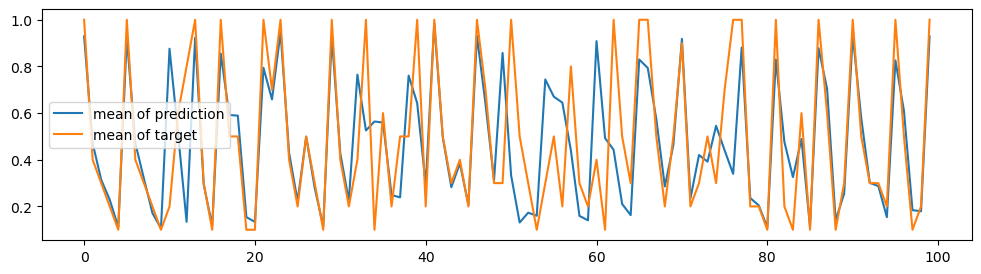

In [280]:
plt.figure(figsize=(12, 3))
# plt.plot(np.linspace(0, 24, 60*24), preds_valid.mean(axis=0), label="mean of prediction")
plt.plot(y_pred[:100], label="mean of prediction")
plt.plot(y[:100].values, label="mean of target")
plt.legend()
plt.show()

In [282]:
df_output = df_final_1[['series_id', 'event', 'step_pred', 'score']].copy()
df_output['event'] = df_output['event'].apply(lambda x: 'wakeup' if x == 1 else 'onset')
df_output['score'] = df_output['score'] * y_pred
df_output.rename(columns={"step_pred": "step"}, inplace=True)
df_output['step'] = df_output['step'].astype('int64')
df_output.to_csv('stage2pred.csv')
df_output

,series_id,event,step,score
0,fe90110788d2,wakeup,581609,2.212676
1,fe90110788d2,wakeup,581765,0.030539
2,fe90110788d2,wakeup,581837,0.010961
3,fe90110788d2,wakeup,581357,0.001784
4,fe90110788d2,wakeup,581249,0.000568
...,...,...,...,...
40845,038441c925bb,wakeup,11213,0.001775
40846,038441c925bb,wakeup,10757,0.002306
40847,038441c925bb,onset,4997,2.885990
40848,038441c925bb,onset,4817,0.006240
